# Housing Crisis Prediction - Full Analysis Notebook

This notebook provides full access to the Housing Crisis Prediction system with:
- Data collection and exploration
- Feature engineering
- Model training (XGBoost, CatBoost, TimesFM, Chronos, STGNN)
- Crisis detection
- Interactive visualizations

**Note:** This is a full Jupyter notebook where you can see, edit, and run all code.

## Setup

In [1]:
import sys
from pathlib import Path

projectRoot = Path().absolute().parent
sys.path.append(str(projectRoot / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pipeline.trainingPipeline import TrainingPipeline
from pipeline.predictionPipeline import PredictionPipeline
from data.dataCollector import DataCollector

import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")
print(f"Project root: {projectRoot}")

✓ Imports successful
Project root: /home/saga/HousingCrisisPredictionEnsemble


## Configuration

In [3]:
fredApiKey = "70922d4a3f67b1699a101896305159f1"

configPath = str(projectRoot / "config" / "config.yaml")

print("Configuration:")
print(f"  FRED API Key: {'Set' if fredApiKey else 'Not set (will use synthetic data)'}")
print(f"  Config Path: {configPath}")

Configuration:
  FRED API Key: Set
  Config Path: /home/saga/HousingCrisisPredictionEnsemble/config/config.yaml


## 1. Data Collection

In [4]:
pipeline = TrainingPipeline(configPath=configPath)
pipeline.initializeDataCollector(fredApiKey=fredApiKey)

print("\nGenerating synthetic demo data...")
dates = pd.date_range(start="2010-01-01", end="2024-12-31", freq="MS")
n = len(dates)

syntheticData = pd.DataFrame(
    {
        "GDP": np.cumsum(np.random.randn(n) * 100 + 50) + 15000,
        "CPIAUCSL": np.cumsum(np.random.randn(n) * 0.5 + 0.2) + 220,
        "UNRATE": np.clip(np.random.randn(n) * 1.5 + 5.5, 3, 10),
        "FEDFUNDS": np.clip(np.random.randn(n) * 0.5 + 2.5, 0, 6),
        "MORTGAGE30US": np.clip(np.random.randn(n) * 0.8 + 4.5, 2.5, 8),
        "HOUST": np.abs(np.random.randn(n) * 200 + 1200),
        "CSUSHPISA": np.cumsum(np.random.randn(n) * 2 + 0.5) + 150,
    },
    index=dates,
)

print(f"\nData shape: {syntheticData.shape}")
print(f"Date range: {syntheticData.index[0]} to {syntheticData.index[-1]}")
syntheticData.head()


Generating synthetic demo data...

Data shape: (180, 7)
Date range: 2010-01-01 00:00:00 to 2024-12-01 00:00:00


,GDP,CPIAUCSL,UNRATE,FEDFUNDS,MORTGAGE30US,HOUST,CSUSHPISA
2010-01-01,15096.144211,221.400309,3.394518,3.888127,4.959184,1258.593580,153.615917
2010-02-01,15030.023080,223.085328,5.733161,2.212746,5.471824,1101.568211,153.532728
2010-03-01,15098.295306,223.416885,4.575009,2.954298,4.223421,995.962800,151.633314
2010-04-01,15099.353841,223.173344,5.440996,1.776077,4.075274,1540.148781,151.578889
2010-05-01,15269.338338,222.554214,3.810963,2.016170,3.443383,1159.957797,153.143679


### Visualize Raw Data

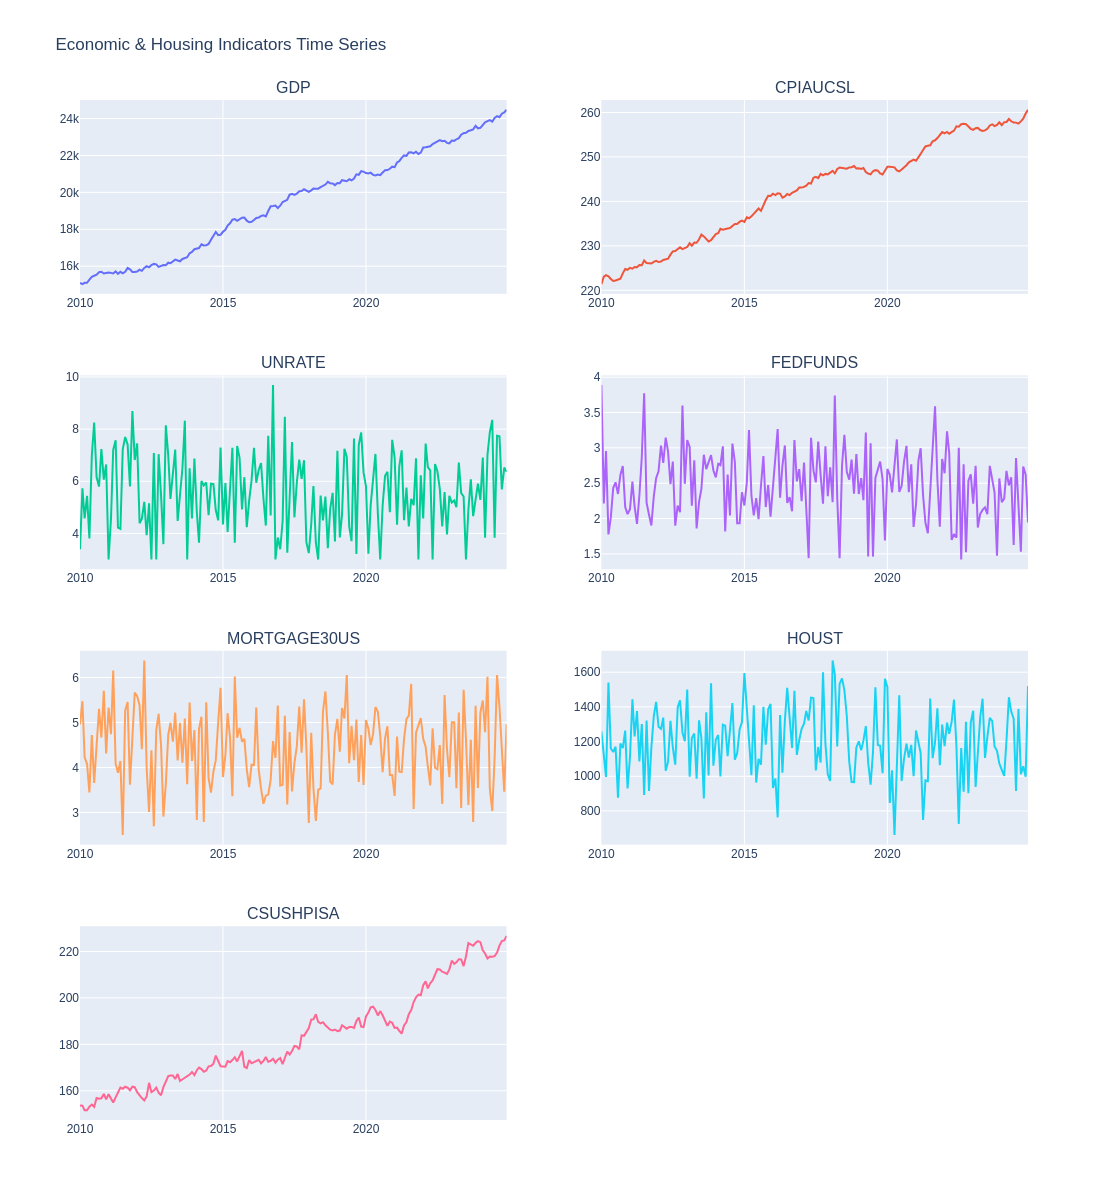

In [5]:
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=list(syntheticData.columns),
    vertical_spacing=0.08
)

for i, col in enumerate(syntheticData.columns):
    row = i // 2 + 1
    col_idx = i % 2 + 1
    
    fig.add_trace(
        go.Scatter(x=syntheticData.index, y=syntheticData[col], name=col, mode='lines'),
        row=row, col=col_idx
    )

fig.update_layout(
    height=1200,
    title_text="Economic & Housing Indicators Time Series",
    showlegend=False
)

fig.show()

## 2. Feature Engineering

In [6]:
print("Engineering features...")
targetColumns = ["CSUSHPISA", "GDP", "UNRATE"]
engineeredData = pipeline.featureEngineer.engineerAllFeatures(
    syntheticData, targetColumns
)

print(f"\nOriginal features: {syntheticData.shape[1]}")
print(f"Engineered features: {engineeredData.shape[1]}")
print(f"New features created: {engineeredData.shape[1] - syntheticData.shape[1]}")

engineeredData.head()

Engineering features...

Original features: 7
Engineered features: 78
New features created: 71


,GDP,CPIAUCSL,UNRATE,FEDFUNDS,MORTGAGE30US,HOUST,CSUSHPISA,month,quarter,year,...,UNRATE_diff_1,UNRATE_diff_12,UNRATE_pct_change_1,UNRATE_pct_change_12,GDP_x_UNRATE,GDP_div_UNRATE,MORTGAGE30US_x_HOUST,MORTGAGE30US_div_HOUST,FEDFUNDS_x_CPIAUCSL,FEDFUNDS_div_CPIAUCSL
2011-01-01,15658.277584,225.073743,3.000000,2.133128,5.327466,1111.954907,158.514432,1,1,2011,...,-3.647031,-0.394518,-0.548671,-0.116222,46974.832753,5219.425844,5923.901793,0.004791,480.111206,0.009477
2011-02-01,15638.239827,224.865596,4.580224,2.523302,4.737277,1444.234211,156.551529,2,1,2011,...,1.580224,-1.152937,0.526741,-0.201100,71626.640816,3414.295876,6841.737240,0.003280,567.403792,0.011221
2011-03-01,15605.671258,225.239449,7.205764,2.169871,6.153769,1230.233791,154.950323,3,1,2011,...,2.625540,2.630755,0.573234,0.575027,112450.787094,2165.720502,7570.574788,0.005002,488.740457,0.009634
2011-04-01,15717.248346,225.194835,7.575190,1.924427,4.084435,1376.339167,157.177288,4,2,2011,...,0.369426,2.134194,0.051268,0.392243,119061.147887,2074.832131,5621.568083,0.002968,433.371020,0.008546
2011-05-01,15585.176704,225.679905,4.220106,2.325974,3.880409,1085.629317,159.553519,5,2,2011,...,-3.355084,0.409143,-0.442904,0.107359,65771.101228,3693.076865,4212.685330,0.003574,524.925669,0.010307


### Feature Correlation Heatmap

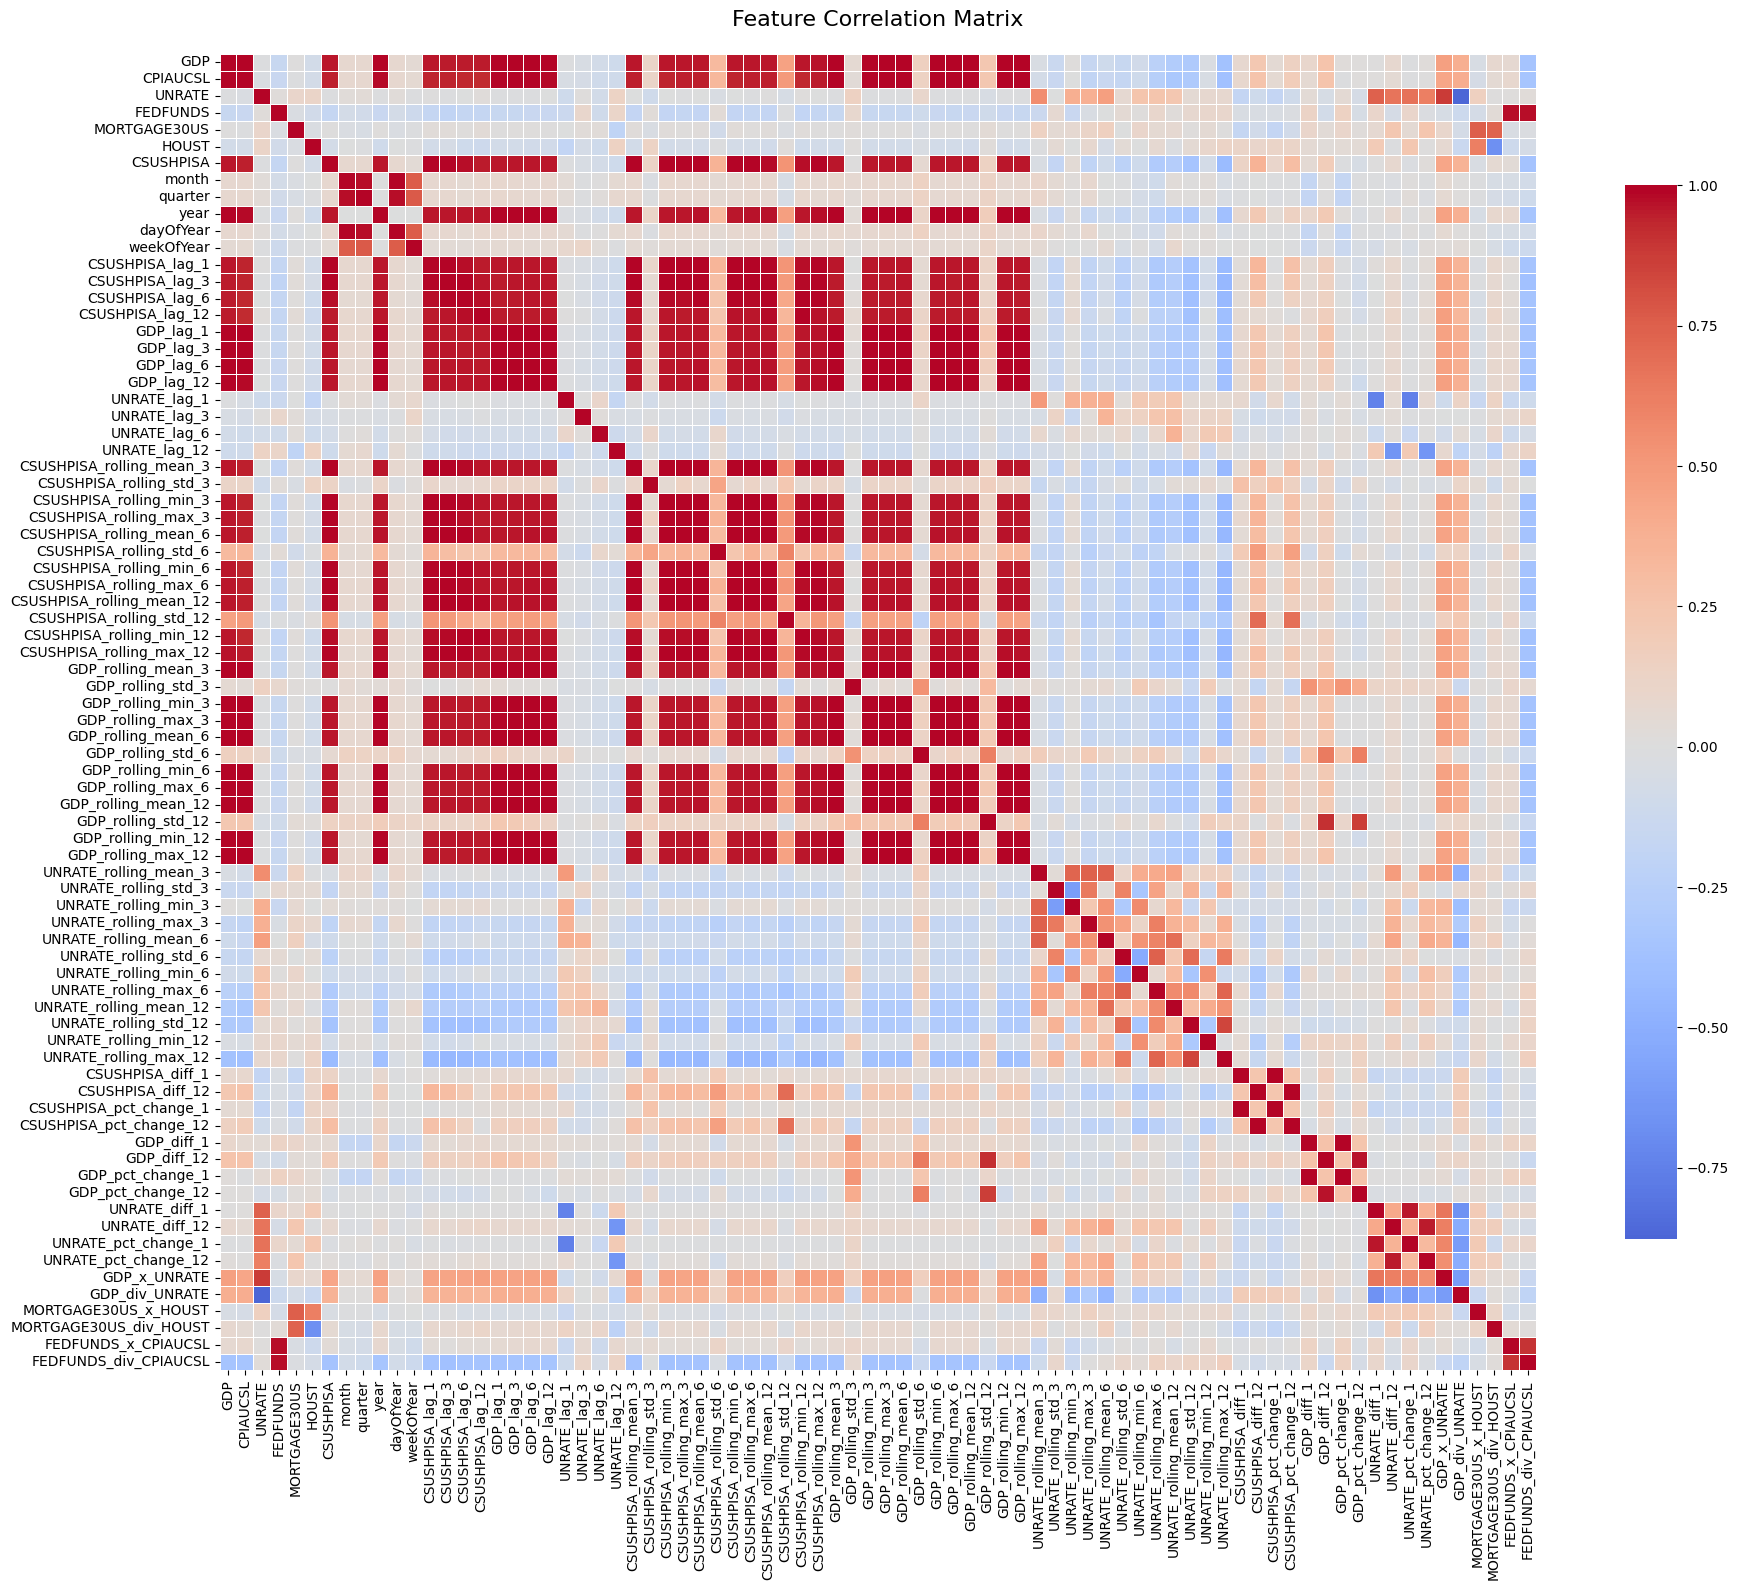

In [7]:
plt.figure(figsize=(20, 16))
correlation = engineeredData.corr()
sns.heatmap(correlation, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## 3. Train/Validation/Test Splits

In [8]:
targetColumn = "CSUSHPISA"
splits = pipeline.prepareTrainTestSplits(engineeredData, targetColumn)

print("Data Splits:")
print(f"  Train: {splits['trainX'].shape[0]} samples, {splits['trainX'].shape[1]} features")
print(f"  Validation: {splits['valX'].shape[0]} samples")
print(f"  Test: {splits['testX'].shape[0]} samples")
print(f"\nTarget distribution:")
print(f"  Train: mean={splits['trainY'].mean():.2f}, std={splits['trainY'].std():.2f}")
print(f"  Validation: mean={splits['valY'].mean():.2f}, std={splits['valY'].std():.2f}")
print(f"  Test: mean={splits['testY'].mean():.2f}, std={splits['testY'].std():.2f}")

Data Splits:
  Train: 117 samples, 77 features
  Validation: 34 samples
  Test: 17 samples

Target distribution:
  Train: mean=174.39, std=11.41
  Validation: mean=202.91, std=11.07
  Test: mean=221.70, std=3.01


## 4. Model Training - Gradient Boosting Ensemble

In [9]:
print("="*70)
print("Training Gradient Boosting Ensemble (XGBoost + CatBoost)")
print("="*70)

gbEnsemble = pipeline.trainGradientBoosting(splits)

print("\n✓ Training complete!")

Training Gradient Boosting Ensemble (XGBoost + CatBoost)

Training Gradient Boosting models...
Training on: NVIDIA GeForce RTX 3060
Training XGBoost...
[0]	validation_0-rmse:29.85759
[1]	validation_0-rmse:29.15661
[2]	validation_0-rmse:28.55759
[3]	validation_0-rmse:27.96240
[4]	validation_0-rmse:27.37632
[5]	validation_0-rmse:26.81907
[6]	validation_0-rmse:26.26388
[7]	validation_0-rmse:25.73375
[8]	validation_0-rmse:25.23607
[9]	validation_0-rmse:24.74751
[10]	validation_0-rmse:24.23820
[11]	validation_0-rmse:23.83929
[12]	validation_0-rmse:23.40789
[13]	validation_0-rmse:22.96234
[14]	validation_0-rmse:22.58201
[15]	validation_0-rmse:22.24997
[16]	validation_0-rmse:21.86441
[17]	validation_0-rmse:21.53268
[18]	validation_0-rmse:21.18123
[19]	validation_0-rmse:20.95108
[20]	validation_0-rmse:20.63086
[21]	validation_0-rmse:20.32749
[22]	validation_0-rmse:20.05196
[23]	validation_0-rmse:19.80253
[24]	validation_0-rmse:19.51693
[25]	validation_0-rmse:19.30109
[26]	validation_0-rmse:19.

### Model Performance Evaluation

In [10]:
print("Validation Set Performance:")
valMetrics = gbEnsemble.evaluate(splits["valX"], splits["valY"])
for modelName, metrics in valMetrics.items():
    print(f"\n{modelName.upper()}:")
    for metricName, value in metrics.items():
        print(f"  {metricName}: {value:.4f}")

print("\n" + "="*70)
print("Test Set Performance:")
testMetrics = gbEnsemble.evaluate(splits["testX"], splits["testY"])
for modelName, metrics in testMetrics.items():
    print(f"\n{modelName.upper()}:")
    for metricName, value in metrics.items():
        print(f"  {metricName}: {value:.4f}")

Validation Set Performance:

ENSEMBLE:
  rmse: 13.8947
  mae: 11.3446
  r2: -0.6232

XGBOOST:
  rmse: 13.8947
  mae: 11.3446
  r2: -0.6232

CATBOOST:
  rmse: 16.1017
  mae: 13.5899
  r2: -1.1797

Test Set Performance:

ENSEMBLE:
  rmse: 28.2229
  mae: 28.0830
  r2: -92.3785

XGBOOST:
  rmse: 28.2229
  mae: 28.0830
  r2: -92.3785

CATBOOST:
  rmse: 31.5494
  mae: 31.3015
  r2: -115.6878


### Feature Importance Analysis

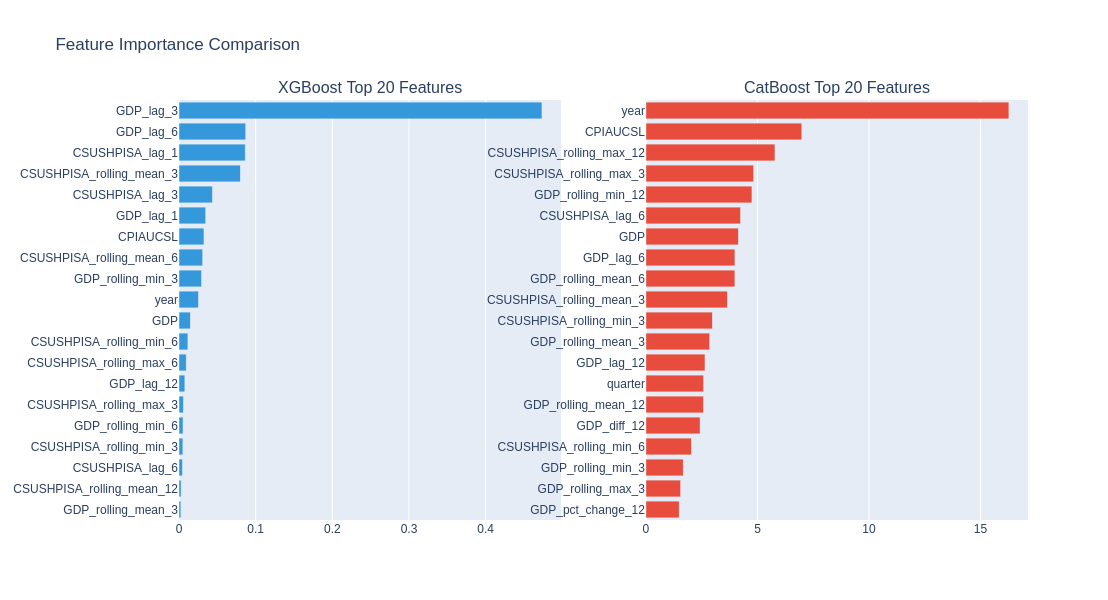

In [11]:
xgbImportance = gbEnsemble.xgbForecaster.getFeatureImportance().head(20)
catImportance = gbEnsemble.catboostForecaster.getFeatureImportance().head(20)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['XGBoost Top 20 Features', 'CatBoost Top 20 Features']
)

fig.add_trace(
    go.Bar(x=xgbImportance['importance'], y=xgbImportance['feature'], 
           orientation='h', name='XGBoost', marker_color='#3498db'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=catImportance['importance'], y=catImportance['feature'], 
           orientation='h', name='CatBoost', marker_color='#e74c3c'),
    row=1, col=2
)

fig.update_layout(height=600, title_text="Feature Importance Comparison", showlegend=False)
fig.update_yaxes(autorange="reversed")
fig.show()

### Prediction vs Actual

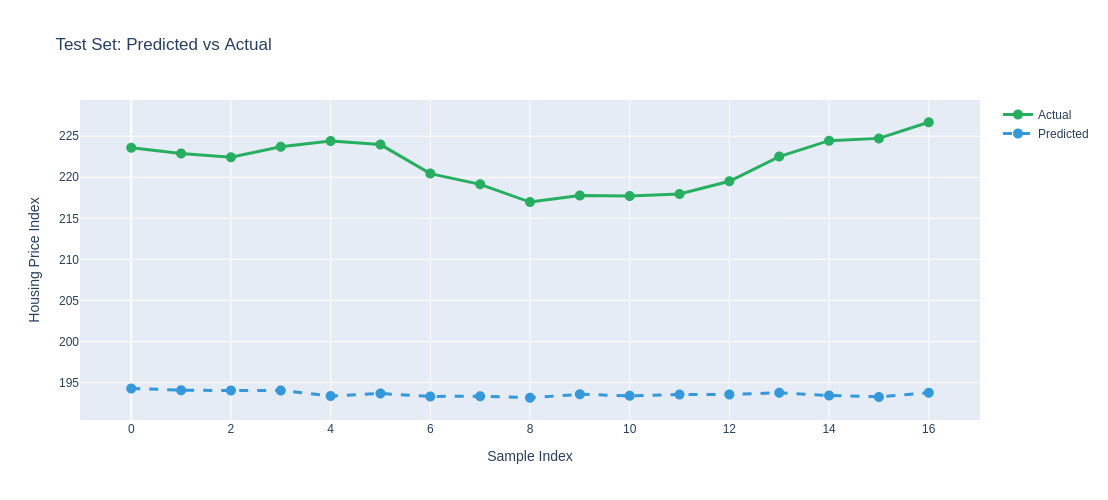

In [12]:
testPredictions = gbEnsemble.predict(splits["testX"])
testActual = splits["testY"].values

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=testActual,
    mode='lines+markers',
    name='Actual',
    line=dict(color='#27ae60', width=3),
    marker=dict(size=10)
))

fig.add_trace(go.Scatter(
    y=testPredictions,
    mode='lines+markers',
    name='Predicted',
    line=dict(color='#3498db', width=3, dash='dash'),
    marker=dict(size=10)
))

fig.update_layout(
    title='Test Set: Predicted vs Actual',
    xaxis_title='Sample Index',
    yaxis_title='Housing Price Index',
    height=500,
    hovermode='x unified'
)

fig.show()

## 5. Crisis Detection & Policy Recommendations

In [13]:
print("="*70)
print("Running Crisis Detection and Policy Recommendations")
print("="*70)

models = {"gradientBoosting": gbEnsemble}
predictionPipeline = PredictionPipeline(
    models=models, configPath=configPath
)

forecastResult = predictionPipeline.runPrediction(
    testX=splits["testX"], 
    historicalY=splits["trainY"].values, 
    targetName=targetColumn
)

print("\n✓ Crisis detection complete!")

Running Crisis Detection and Policy Recommendations
Generating forecasts...
HOUSING CRISIS PREDICTION REPORT

Target: CSUSHPISA
Forecast Horizon: 12 months

CRISIS ASSESSMENT
Crisis Level: LOW
Crisis Score: -0.265
Price Decline Risk: 0.0%
Rapid Appreciation Risk: 0.0%
Volatility Increase: -88.3%

POLICY RECOMMENDATIONS
1. OPTIMIZATION: Continue routine market monitoring
2. Refine predictive models with latest data
3. Conduct policy impact simulations
4. Analyze long-term market trends
5. Maintain early warning system vigilance

FORECAST SUMMARY
Mean Predicted Value: 193.62
Predicted Range: [193.15, 194.29]
Predicted Std Dev: 0.32


✓ Crisis detection complete!


## 6. Interactive Experimentation

Use the cells below to experiment with different parameters, models, and analyses.

In [14]:
# Experiment cell - modify as needed
# Example: Try different forecast horizons

horizons = [6, 12, 24, 36]
for h in horizons:
    print(f"\nForecast horizon: {h} months")
    # Add your experimentation code here


Forecast horizon: 6 months

Forecast horizon: 12 months

Forecast horizon: 24 months

Forecast horizon: 36 months


## Summary

This notebook demonstrated:
- ✓ Data collection and exploration
- ✓ Feature engineering (77 features from 7 base indicators)
- ✓ Gradient boosting ensemble training
- ✓ Model evaluation and comparison
- ✓ Feature importance analysis
- ✓ Crisis detection